<h3>How far is a point from a coastline?</h3>

This notebook compares points along a tropical cyclone's track, as obtained from the International Best Track Archive for Climate Stewardship (IBTrACS) database, to the Global Self-consistent Hierarchical High-resolution Geography worldwide coastline data to determine how far each point is from a coastline (i.e., the perimeter of the polygons defining the coastlines shapefile). Our specific application is to determine if a point is over land (i.e., inside a coastline polygon).

Resources:
<ul>
    <li><b>IBTrACS</b>: <a href="https://www.ncei.noaa.gov/products/international-best-track-archive" target="_blank">https://www.ncei.noaa.gov/products/international-best-track-archive</a>.</li>
    <li><b>Global Self-consistent Hierarchical High-resolution Geography</b>: <a href="https://www.soest.hawaii.edu/pwessel/gshhg/" target="_blank">https://www.soest.hawaii.edu/pwessel/gshhg/</a>, as described in Wessel and Smith (1996, <i>J. Geophys. Res.</i>). This is the dataset used by IBTrACS to compute the DIST2LAND parameter, per the <a href="https://www.ncei.noaa.gov/sites/default/files/2021-07/IBTrACS_version4_Technical_Details.pdf" target="_blank">IBTrACS Technical Documentation</a>.</li>

<hr>

We start by importing the needed modules.

In [1]:
# Import needed modules.
import pandas as pd
import geopandas as gpd
import urllib.request
import zipfile

Next, we want to download, unpack, and open the GSHHG coastline data. These data come in five resolutions, the finest of which is sub-kilometer globally. The second-highest, defined by the authors as "high resolution," reduces the data load by ~80% and is sufficient for our purposes. We open only the L1 data, which correspond to continents and ocean islands excepting Antarctica; L2 through L6 include features interior to continents and Antarctic features that are not relevant for our purposes.

0         POLYGON ((180.00000 68.99378, 180.00000 65.034...
1         POLYGON ((-180.00000 68.99378, -179.99844 68.9...
2         POLYGON ((32.28458 31.22667, 32.28450 31.23281...
3         POLYGON ((-79.94869 9.31397, -79.92538 9.31240...
4         POLYGON ((-73.36172 -53.00042, -73.36261 -53.0...
                                ...                        
144744    POLYGON ((-107.61875 66.91806, -107.61717 66.9...
144745    POLYGON ((-119.40472 77.24386, -119.40653 77.2...
144746    POLYGON ((-119.85378 77.06967, -119.85378 77.0...
144747    POLYGON ((-119.94606 77.03406, -119.94550 77.0...
144748    POLYGON ((-119.97297 77.02950, -119.97469 77.0...
Name: geometry, Length: 144749, dtype: geometry


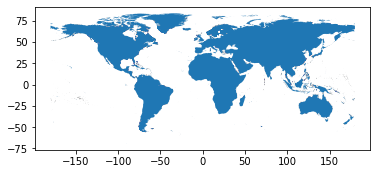

In [2]:
# Download the GSHHG data.
urllib.request.urlretrieve("http://www.soest.hawaii.edu/pwessel/gshhg/gshhg-shp-2.3.7.zip", "gshhg-shp.zip")

# Unpack the downloaded zip file. This will take a
# few minutes because the data are fairly large.
with zipfile.ZipFile("gshhg-shp.zip", 'r') as file:
    file.extractall(".")

# Open the desired coastline shapefile; see the discussion
# above for more specifics about this file.
coastline = gpd.read_file('GSHHS_shp/h/GSHHS_h_L1.shp')

# Create a quick plot to confirm the coastlines
# are retained and shaped as we expect.
coastline.plot()

# Print the coastline GeoDataFrame's geometry column
# to inspect the data.
print(coastline.geometry)

We also want to open the IBTrACS archive. For this purpose, we use the 1980-present IBTrACS data <a href="https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r00/access/csv/ibtracs.since1980.list.v04r00.csv">from NCEI</a>.

In [3]:
# Open IBTrACS data. We'll ignore the DtypeWarning (for columns
# with mixed inferred data types) that appears upon trying to
# read these data.
tcdata = pd.read_csv("https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r00/access/csv/ibtracs.since1980.list.v04r00.csv",dtype={'USA_LAT':'str','USA_LON':'str','STORM_SPEED':'str','STORM_DIR':'str'}, index_col=[0], parse_dates=[6])

/opt/tljh/user/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (1,2,8,9,14) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


For testing purposes, let us isolate a single tropical cyclone in the IBTrACS archive. In this case, we will retain North Atlantic Tropical Storm Erin from 2007. We do this by filtering the tcdata DataFrame by the name and season columns.

In [4]:
tcdata_parsed = tcdata[(tcdata['NAME'] == 'ERIN') & (tcdata['SEASON'] == 2007)]

We want to convert the IBTrACS data to a GeoDataFrame. To do so requires a geometry be added for each row of the DataFrame. We will use the TC's location (latitude and longitude) to define a point geometry for each row.

In [5]:
# Note that the crs of EPSG:4326 corresponds to the WGS-84 latitude-longitude projection.
tcdata_geom = gpd.GeoDataFrame(tcdata_parsed, geometry=gpd.points_from_xy(tcdata_parsed['LON'], tcdata_parsed['LAT'], crs='EPSG:4326'))
print(tcdata_geom)

              SEASON NUMBER BASIN SUBBASIN  NAME             ISO_TIME NATURE  \
SID                                                                            
2007227N24269   2007     46   NaN       GM  ERIN  2007-08-15 00:00:00     TS   
2007227N24269   2007     46   NaN       GM  ERIN  2007-08-15 03:00:00     TS   
2007227N24269   2007     46   NaN       GM  ERIN  2007-08-15 06:00:00     TS   
2007227N24269   2007     46   NaN       GM  ERIN  2007-08-15 09:00:00     TS   
2007227N24269   2007     46   NaN       GM  ERIN  2007-08-15 12:00:00     TS   
2007227N24269   2007     46   NaN       GM  ERIN  2007-08-15 15:00:00     TS   
2007227N24269   2007     46   NaN       GM  ERIN  2007-08-15 18:00:00     TS   
2007227N24269   2007     46   NaN       GM  ERIN  2007-08-15 21:00:00     TS   
2007227N24269   2007     46   NaN       GM  ERIN  2007-08-16 00:00:00     TS   
2007227N24269   2007     46   NaN       GM  ERIN  2007-08-16 03:00:00     TS   
2007227N24269   2007     46   NaN       

We want to make sure that both sets of geometries - the coastline data and the IBTrACS TC track points - have the same coordinate reference system (CRS) with a specification of meters (rather than degrees) as its basis. We will use geopandas' to_crs function to set both to EPSG:3857, which is a pseudo-Mercator projection based on the WGS 84 datum (EPSG:4326). If you are only considering a fixed part of the globe, you may obtain better results with a narrower CRS definition.

In [6]:
coastline = coastline.to_crs('EPSG:3857')
tcdata_geom = tcdata_geom.to_crs('EPSG:3857')

Finally, we compute the minimum distance from each track point to the coast, determine if it is inland, and append the result to a new list that will ultimately have the same length as the number of TC track points considered. To do so, we make use of shapely's <i>distance</i> function, applied to the coastline polygons' exteriors, to find the distance to the coast and shapely's <i>contains</i> function to determine whether the track point is inside of the polygon.

In [7]:
# Iterate over the TC track points' geometries.
# The exterior.distance() function computes the distance to the
#   shapefile polygons' exteriors.
# The returned values are in m, so dividing by 1000 gives us km.
# We retain only the minimum distance, representing that to the
#   nearest coastline, and find the index of the coastline
#   shapefile that corresponds to that minimum distance.
# We then determine if that location is inland (i.e., inside
#   the coastline polygon) using the contains function.
# Finally, we append the distance and whether it is inland or
#   not to the dists and inland lists.
dists = []
inland = []
for tcloc in tcdata_geom.geometry:
    dist_to_coast = coastline.exterior.distance(tcloc)/1000.
    dist = dist_to_coast.min()
    dist_idx = dist_to_coast.idxmin()
    is_inland = coastline.contains(tcloc)[dist_idx]
    dists.append(dist)
    inland.append(is_inland)

To wrap things up, we append this new list to the tcdata_parsed DataFrame so that it can be used for other purposes.

In [8]:
tcdata_parsed['dist_to_coast'] = dists
tcdata_parsed['is_inland'] = inland
print(tcdata_parsed)

              SEASON NUMBER BASIN SUBBASIN  NAME             ISO_TIME NATURE  \
SID                                                                            
2007227N24269   2007     46   NaN       GM  ERIN  2007-08-15 00:00:00     TS   
2007227N24269   2007     46   NaN       GM  ERIN  2007-08-15 03:00:00     TS   
2007227N24269   2007     46   NaN       GM  ERIN  2007-08-15 06:00:00     TS   
2007227N24269   2007     46   NaN       GM  ERIN  2007-08-15 09:00:00     TS   
2007227N24269   2007     46   NaN       GM  ERIN  2007-08-15 12:00:00     TS   
2007227N24269   2007     46   NaN       GM  ERIN  2007-08-15 15:00:00     TS   
2007227N24269   2007     46   NaN       GM  ERIN  2007-08-15 18:00:00     TS   
2007227N24269   2007     46   NaN       GM  ERIN  2007-08-15 21:00:00     TS   
2007227N24269   2007     46   NaN       GM  ERIN  2007-08-16 00:00:00     TS   
2007227N24269   2007     46   NaN       GM  ERIN  2007-08-16 03:00:00     TS   
2007227N24269   2007     46   NaN       

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
